In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

In [3]:
df = pd.read_excel('data/IncidentiModificato.xlsx', index_col='VERBALE')

X = df[['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y = df['Mezzo']

df.head()

,DATA,SESSO,ANNI,PESO,ALTEZZA,BMI,Mezzo,Testa:Neurocranio,Testa:Splancnocranio,Testa:Telencefalo,...,Scheletro:Rachide-cervicale,Scheletro:Rachide-toracico,Scheletro:Rachide-lombare,Scheletro:Bacino-e-sacro,Scheletro:Complesso-sterno/claveo/costale,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro,Totale
VERBALE,,,,,,,,,,,,,,,,,,,,,
85567,1999-10-29,0,81,84.0,1.75,27.428571,0,1,0,0,...,0,3,0,3,3,2,0,3,9,14
85829,2000-01-14,1,69,69.0,1.62,26.291724,1,4,4,4,...,0,0,0,0,4,20,7,1,4,32
85977,2000-03-10,1,71,67.0,1.55,27.887617,1,2,0,1,...,0,0,0,0,4,6,0,0,4,10
86220,2000-06-14,1,54,60.0,1.59,23.733238,1,4,0,0,...,0,0,0,0,4,5,3,2,4,14
86247,2000-06-22,1,78,69.0,1.67,24.740937,1,2,0,0,...,0,0,0,0,4,2,0,2,4,8


In [82]:
from sklearn.decomposition import PCA
pd.options.mode.chained_assignment = None  # default='warn'

def get_X_pca_totals(dataframe):
    X_pca = dataframe[['SESSO', 'ANNI', 'PESO', 'ALTEZZA','BMI']]

    for parte_corpo in ['Testa', 'Torace', 'Addome', 'Scheletro']:
        pca = PCA(n_components=1).fit_transform(dataframe.filter(regex=parte_corpo+":"))
        X_pca['PCA ' + parte_corpo] = pca
    
    return X_pca

def perturb(n, x):
    if n + x >= 0 and n + x <= 4:
        return n + x
    else:
        return n - x
    

def add_new_elements_pca(df, perturbation_kind="personal_data", error_distrib = None, n_elements=200, n_columns=3):
    assert(perturbation_kind in ['personal_data', 'body_parts', 'both'])
    df_no_totals = df.drop(columns=df.columns[-5:]) #tolgo i totali per ricalcolarli dopo
    dati_persona = ['DATA', 'SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Mezzo']
    df_dati_persona = df_no_totals[dati_persona]
    df_parti_corpo = df_no_totals.drop(columns=dati_persona)

    if error_distrib:
        x = error_distrib['x']
        px = error_distrib['px']

    count_elements = 0
    
    while len(df_no_totals) < n_elements:
        index = np.random.choice(df_parti_corpo.index)
        new_index = "FAKE_" + str(index) + "_" + str(count_elements)
        count_elements+=1
        
        parti_corpo = df_parti_corpo.loc[index]
        dati_persona = df_dati_persona.loc[index]
        
        if perturbation_kind == "body_parts" or perturbation_kind == "both":
            pert = parti_corpo.sample(n_columns) 

            for (i,e) in zip(pert.index, pert.values):
                perturbation = np.random.choice(x,p=px)
                parti_corpo[i] = perturb(e,perturbation)
        
        if perturbation_kind == "personal_data" or perturbation_kind == "both":
            for (i,e) in zip(dati_persona.index, dati_persona.values):
                if i == 'ANNI':
                    perturbation = int(np.random.normal(0, 1)) #normale centrata in zero e std = 1 anno
                    dati_persona[i] += perturbation
                if i == 'PESO':
                    perturbation = round(np.random.normal(0, 2), 1) #normale centrata in zero e std = 2kg
                    dati_persona[i] += perturbation
                if i == 'ALTEZZA':
                    perturbation = round(np.random.normal(0, 0.01), 2) #normale centrata in zero e std = 1cm
                    dati_persona[i] += perturbation                
        
            dati_persona['BMI'] = dati_persona['PESO'] / (dati_persona['ALTEZZA'] ** 2) #ricalcolo il BMI
            
        
        new_elem = parti_corpo.append(dati_persona)
        df_no_totals.loc[new_index] = new_elem
        
        df_no_totals = df_no_totals.drop_duplicates()

    X_pca = get_X_pca_totals(df_no_totals)

    return X_pca, df_no_totals['Mezzo']

In [16]:
def get_accuracies(df, params, _range, perturbation_kind): 
    accuracies = {'n_data' : [], 'activation': [], 'hidden layer sizes' : [], 'best score' : []}
    
    X = get_X_pca_totals(df)
    y = df['Mezzo']
    
    X_std = StandardScaler().fit_transform(X)
    
    mlp = MLPClassifier(learning_rate_init=0.001, max_iter=5000, learning_rate="adaptive")
    clf = GridSearchCV(mlp, params, n_jobs=-1, cv=5)
    clf.fit(X_std,y)

    accuracies['n_data'].append(len(y))
    accuracies['activation'].append(clf.best_estimator_.activation)
    accuracies['hidden layer sizes'].append(clf.best_estimator_.hidden_layer_sizes)
    accuracies['best score'].append(clf.best_score_)
    
    error_distrib = {
        'x' : [-2,-1,0,1,2],
        'px' : [.1,.2,.4,.2,.1]
    }   

    for n_data in _range:

        X_os, y_os = add_new_elements_pca(df=df, perturbation_kind=perturbation_kind, error_distrib=error_distrib, n_elements=n_data, n_columns=3)

        X_os_std = StandardScaler().fit_transform(X_os)

        mlp = MLPClassifier(learning_rate_init=0.001, max_iter=5000, learning_rate="adaptive")
        clf = GridSearchCV(mlp, params, n_jobs=-1, cv=5)
        clf.fit(X_os_std,y_os)

        accuracies['n_data'].append(len(y_os))
        accuracies['activation'].append(clf.best_estimator_.activation)
        accuracies['hidden layer sizes'].append(clf.best_estimator_.hidden_layer_sizes)
        accuracies['best score'].append(clf.best_score_)

    return pd.DataFrame(accuracies)

# Perturbazione solo su dati personali

In questo esperimento ho provato a perturbare i dati personali con distribuzione normale (ovvero l'età, il peso e l'altezza, ricalcolando il BMI in base ai nuovi dati) lasciando invariati i dati sulle lesioni del corpo. 

I nuovi dati sono stati ottenuti nel seguente modo: 

```if i == 'ANNI':
    perturbation = int(np.random.normal(0, 1)) #normale centrata in zero e std = 1 anno
if i == 'PESO':
    perturbation = round(np.random.normal(0, 2), 1) #normale centrata in zero e std = 2kg
if i == 'ALTEZZA':
    perturbation = round(np.random.normal(0, 0.01), 2) #normale centrata in zero e std = 1cm
dati_persona[i] += perturbation```

In [30]:
params = {'activation': ['relu', 'logistic', 'tanh'],
          'hidden_layer_sizes' : [(2), (3,3), (5), (6,3), (5,5),(6), (8), (10), (20)]}

_range = [x for x in range(140, 200, 10)] + [x for x in range(200,2000,100)] + [2**e for e in range(11,15)]

%time personal_data_acc = get_accuracies(df, params, _range, perturbation_kind="personal_data")

Wall time: 1h 4min 20s


In [31]:
personal_data_acc

,n_data,activation,hidden layer sizes,best score
0,130,tanh,2,0.707692
1,140,logistic,5,0.714286
2,150,relu,20,0.726667
3,160,tanh,10,0.768750
4,170,relu,20,0.758824
5,180,tanh,20,0.794444
6,190,tanh,10,0.842105
7,200,relu,20,0.885000
8,300,tanh,20,0.940000
9,400,tanh,20,0.962500


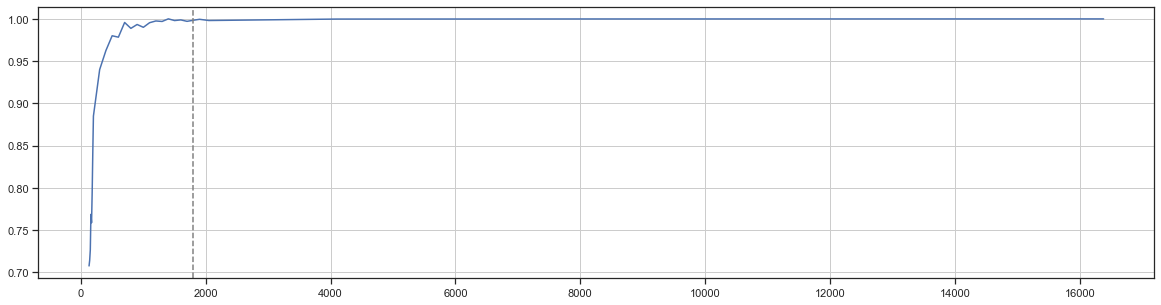

In [71]:
plt.figure(figsize=(20,5))
plt.plot(personal_data_acc['n_data'], personal_data_acc['best score'])
plt.grid(True)
plt.axvline(1800, 0, 1, color='grey', ls='--')

plt.show()

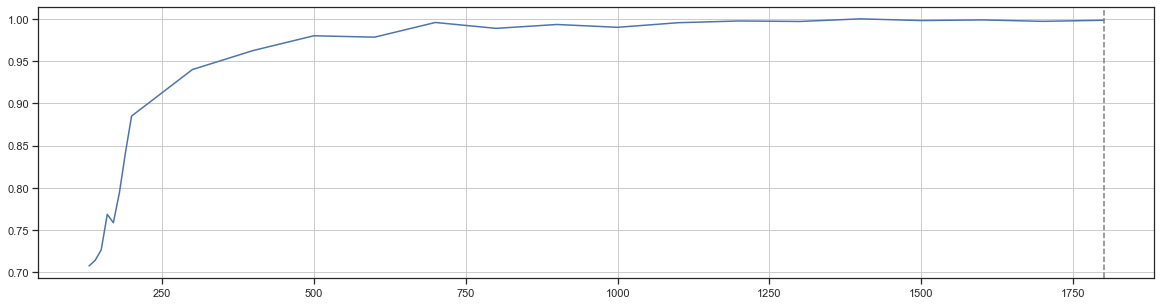

In [72]:
plt.figure(figsize=(20,5))
plt.plot(personal_data_acc['n_data'][:-5], personal_data_acc['best score'][:-5])
plt.grid(True)
plt.axvline(1800, 0, 1, color='grey', ls='--')
plt.show()

# Perturbazione solo su lesioni nel corpo

In questo esperimento ho provato a perturbare le lesioni del corpo (solo 3 colonne su 20) lasciando invariati i dati personali. 

I nuovi dati sono stati ottenuti nel seguente modo: `new = old + disturbo`, dove `disturbo` è `[-2,-1,0,1,2]` con  probabilità `[.1,.2,.4,.2,.1]` (ovviamente restando sempre dentro il range 0,4).

In [34]:
%time body_parts_acc = get_accuracies(df, params, _range, perturbation_kind="body_parts")

Wall time: 39min 25s


In [35]:
body_parts_acc

,n_data,activation,hidden layer sizes,best score
0,130,logistic,8,0.700000
1,140,relu,10,0.685714
2,150,tanh,10,0.780000
3,160,tanh,20,0.775000
4,170,tanh,20,0.782353
5,180,tanh,8,0.772222
6,190,tanh,20,0.800000
7,200,tanh,20,0.830000
8,300,tanh,20,0.923333
9,400,tanh,20,0.935000


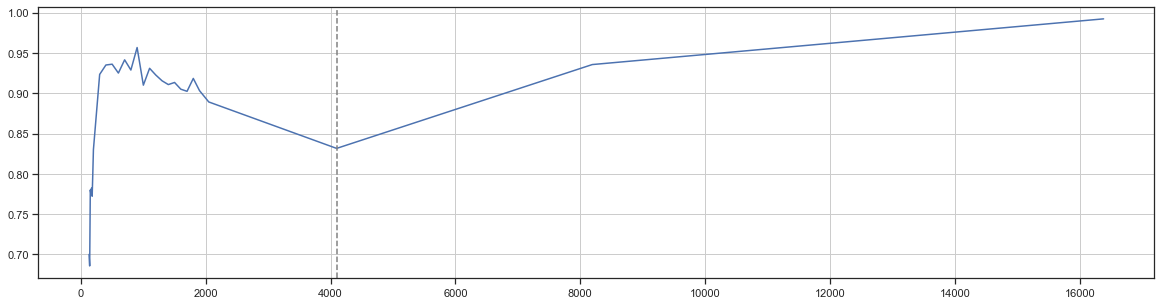

In [69]:
plt.figure(figsize=(20,5))
plt.plot(body_parts_acc['n_data'], body_parts_acc['best score'])
plt.grid(True)
plt.axvline(4096, 0, 1, color='grey', ls='--')
plt.show()

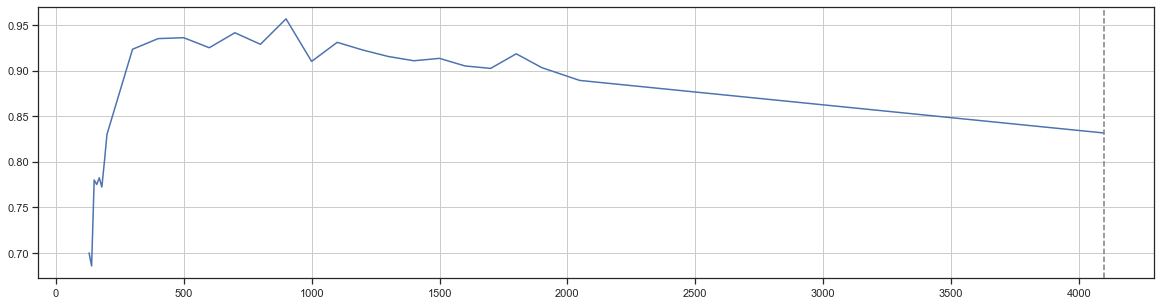

In [70]:
plt.figure(figsize=(20,5))
plt.plot(body_parts_acc['n_data'][:-2], body_parts_acc['best score'][:-2])
plt.grid(True)
plt.axvline(4096, 0, 1, color='grey', ls='--')
plt.show()

# Perturbazione su tutto

In questo esperimento ho provato ad unire le due cose, mantenendo esattemente gli stessi metodi di perturbazione.

In [37]:
%time both_acc = get_accuracies(df, params, _range, perturbation_kind="both")

Wall time: 34min 49s


In [38]:
both_acc

,n_data,activation,hidden layer sizes,best score
0,130,tanh,5,0.707692
1,140,logistic,6,0.700000
2,150,relu,8,0.740000
3,160,tanh,10,0.775000
4,170,tanh,8,0.747059
5,180,tanh,20,0.777778
6,190,tanh,10,0.789474
7,200,tanh,20,0.815000
8,300,tanh,20,0.910000
9,400,tanh,20,0.907500


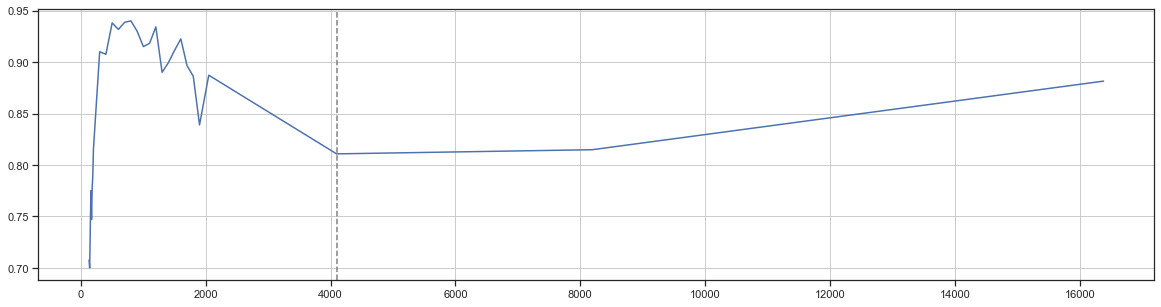

In [67]:
plt.figure(figsize=(20,5))
plt.plot(both_acc['n_data'], both_acc['best score'])
plt.axvline(4096, 0, 1, color='grey', ls='--')
plt.grid(True)
plt.show()

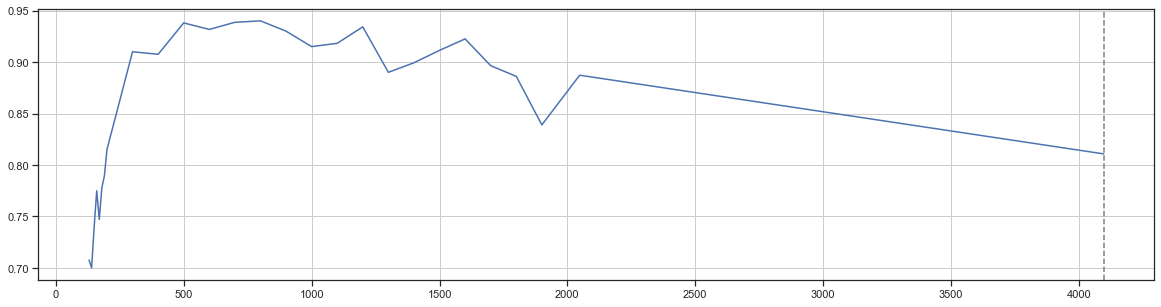

In [68]:
plt.figure(figsize=(20,5))
plt.plot(both_acc['n_data'][:-2], both_acc['best score'][:-2])
plt.axvline(4096, 0, 1, color='grey', ls='--')
plt.grid(True)
plt.show()

In [74]:
A , B = add_new_elements_pca(df, n_elements=500)

In [75]:
A

,SESSO,ANNI,PESO,ALTEZZA,BMI,PCA Testa,PCA Torace,PCA Addome,PCA Scheletro
VERBALE,,,,,,,,,
85567,0,81,84.0,1.75,27.428571,-1.293353,-1.558764,0.870418,1.918211
85829,1,69,69.0,1.62,26.291724,6.521466,1.542402,-0.617494,-0.605109
85977,1,71,67.0,1.55,27.887617,0.494459,-1.558764,-1.361451,-0.605109
86220,1,54,60.0,1.59,23.733238,0.318119,-0.171118,-0.085887,-0.605109
86247,1,78,69.0,1.67,24.740937,-1.084990,-1.558764,-1.068132,-0.605109
...,...,...,...,...,...,...,...,...,...
FAKE_95401_382,0,49,81.6,1.65,29.972452,6.521466,1.778081,2.873425,0.980707
FAKE_101544_383,1,69,84.3,1.57,34.200170,1.344872,-1.558764,-1.361451,-2.114734
FAKE_94145_384,0,80,66.5,1.56,27.325773,-1.618686,-0.699310,-1.214791,-1.452908
